In [21]:
import os
import numpy as np
import pandas as pd
import csv
from datetime import datetime
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.api as sm

from definitions import target_var, country_col, date_col, save_output, fake_num, show_plots, save_figs,fig_size 
from util_general import get_table_path, get_impl_date, get_trans, get_donor_countries
from plot_functions import plot_predictions, plot_diff, plot_cumsum, plot_cumsum_impl, plot_qq
from statistical_tests import shapiro_wilk_test, t_test_result

# custom functions
from definitions import all_paths, country_col, year_col, stat, incl_countries, incl_years, model_val
from util_general import read_data, validate_input, get_trans, get_data_path, get_impl_date
from estimators import arco, sc, did

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from sklearn.linear_model import Lasso
from definitions import fig_size, show_plots, save_figs, treatment_countries
from util_general import get_impl_date, get_fig_path, get_formal_title, get_model_color, get_formal_country_name

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import coint

In [2]:
timeframe = 'm'
treatment_country = 'switzerland'
model = 'lasso'
fig_size = (10, 6)

In [4]:
df = read_data(source_path=get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}')
df = df[(df[country_col].isin(incl_countries)) & (df[year_col].isin(incl_years))]
df

,country,date,year,month,co2,gdp,ind_prod,infl,unempl,pop,brent
0,austria,2000-01-01,2000,1,9.726928e+09,0.009051,-0.028,-0.004,0.043,8.003000e+06,25.51
1,austria,2000-02-01,2000,2,8.532685e+09,0.008627,0.043,0.008,0.043,8.004700e+06,27.78
2,austria,2000-03-01,2000,3,8.134567e+09,0.008203,0.006,0.001,0.041,8.006400e+06,27.49
3,austria,2000-04-01,2000,4,6.546738e+09,0.007778,0.018,-0.002,0.038,8.008100e+06,22.76
4,austria,2000-05-01,2000,5,5.603262e+09,0.007029,0.020,-0.001,0.037,8.010100e+06,27.74
...,...,...,...,...,...,...,...,...,...,...,...
4517,united_kingdom,2019-06-01,2019,6,2.864851e+10,0.004439,-0.005,0.000,0.038,6.684433e+07,64.22
4518,united_kingdom,2019-07-01,2019,7,2.872032e+10,0.006109,-0.002,0.000,0.038,6.686800e+07,63.92
4519,united_kingdom,2019-08-01,2019,8,2.809851e+10,0.003989,-0.008,0.004,0.038,6.689167e+07,59.04
4520,united_kingdom,2019-09-01,2019,9,3.070698e+10,0.001869,0.004,0.001,0.037,6.691533e+07,62.83


In [26]:
df_stat = read_data(source_path=get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}_non_stat')
df_stat = df_stat[(df_stat[country_col].isin(incl_countries)) & (df_stat[year_col].isin(incl_years))]
df_stat

,country,date,year,month,co2,gdp,ind_prod,infl,unempl,pop,brent
0,austria,2001-01-01,2001,1,-0.019138,-0.002088,-0.019,-0.004,-0.027399,0.000320,-0.001560
1,austria,2001-02-01,2001,2,0.039611,-0.001670,0.018,0.003,0.000000,0.000353,0.070813
2,austria,2001-03-01,2001,3,0.022160,-0.001253,-0.011,-0.001,0.027399,0.000353,-0.115513
3,austria,2001-04-01,2001,4,0.119718,-0.000835,-0.015,0.003,0.052644,0.000353,0.046260
4,austria,2001-05-01,2001,5,0.024326,-0.000423,0.000,-0.003,0.025318,0.000390,0.098282
...,...,...,...,...,...,...,...,...,...,...,...
4289,united_kingdom,2019-06-01,2019,6,-0.017357,0.004439,-0.005,-0.003,0.000000,0.000354,-0.104862
4290,united_kingdom,2019-07-01,2019,7,-0.034553,0.006109,-0.002,0.000,0.000000,0.000354,-0.004682
4291,united_kingdom,2019-08-01,2019,8,-0.020662,0.003989,-0.008,0.004,0.000000,0.000354,-0.079417
4292,united_kingdom,2019-09-01,2019,9,-0.005156,0.001869,0.004,-0.003,-0.026668,0.000354,0.062217


# COINT

In [27]:
from statsmodels.tsa.stattools import coint

df_stat_country = df_stat[df_stat[country_col]==treatment_country]
df_stat_country = df_stat_country.set_index(date_col)[get_trans()]
df_stat_country.index = pd.to_datetime(df_stat_country.index)

for var_1 in df_stat_country.columns:
    print(f'{var_1}')
    for var_2 in df_stat_country.columns.drop([var_1]):
        p_value = coint(df_stat_country[var_1], y1=df_stat_country[var_2])[1]
        if p_value < 0.05:
            print(f' \t {var_2} is cointegrated (p-value={p_value})')
        else:
            print(f' \t {var_2} is NOT cointegrated (p-value={p_value})')
    print('\n')

co2
 	 gdp is cointegrated (p-value=2.7009013916714347e-05)
 	 ind_prod is cointegrated (p-value=3.879270540642812e-05)
 	 infl is cointegrated (p-value=3.705203606173192e-05)
 	 unempl is cointegrated (p-value=3.8511332505138594e-05)
 	 pop is cointegrated (p-value=2.7251344009859868e-05)
 	 brent is cointegrated (p-value=3.3899682897688066e-05)


gdp
 	 co2 is cointegrated (p-value=0.008964803753737895)
 	 ind_prod is cointegrated (p-value=0.012508566760337932)
 	 infl is cointegrated (p-value=0.012645881989849214)
 	 unempl is cointegrated (p-value=0.0065595028867274285)
 	 pop is cointegrated (p-value=0.012790176190950102)
 	 brent is cointegrated (p-value=0.0007351933183370959)


ind_prod
 	 co2 is cointegrated (p-value=0.04068285252013183)
 	 gdp is cointegrated (p-value=0.035285848910853804)
 	 infl is cointegrated (p-value=0.03514135460150977)
 	 unempl is NOT cointegrated (p-value=0.059695696685674864)
 	 pop is cointegrated (p-value=0.04257405054351357)
 	 brent is cointegrat

# Johansen test

In [28]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

jres = coint_johansen(df_stat_country, det_order=0, k_ar_diff=1)

In [29]:
# trace test
print(jres.trace_stat)
print(jres.trace_stat_crit_vals)

[639.08130137 466.83161802 296.57985816 196.15665569 110.53462069
  50.66737311  10.10468374]
[[120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [30]:
# eigenvalue test
print(jres.max_eig_stat)
print(jres.max_eig_stat_crit_vals)

[172.24968335 170.25175986 100.42320247  85.622035    59.86724758
  40.56268937  10.10468374]
[[43.2947 46.2299 52.3069]
 [37.2786 40.0763 45.8662]
 [31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


# Adfuller

In [53]:
from statsmodels.tsa.stattools import adfuller

df_stat_country = df_stat[df_stat[country_col]==treatment_country]
df_stat_country = df_stat_country.set_index(date_col)[get_trans()]
df_stat_country.index = pd.to_datetime(df_stat_country.index)

var_1_list = []
var_2_list = []
p_value_list = []
for var_1 in df_stat_country.columns:
    print(f'{var_1}')
    for var_2 in df_stat_country.columns.drop([var_1]):
        var_1_list.append(var_1)
        var_2_list.append(var_2)
        
        ols = sm.OLS(df_stat_country[var_1], df_stat_country[var_2]).fit()
        p_value = adfuller(ols.resid)[1]
        p_value_list.append(p_value)
        if p_value > 0.10:
            print(f' \t {var_2} is cointegrated (p-value={p_value})')
        else:
            print(f' \t {var_2} is NOT cointegrated (p-value={p_value})')
    print('\n')
    
coint_res = pd.DataFrame(list(zip(var_1_list, var_2_list, p_value_list)), columns=['var1', 'var2', 'p'])
coint_res = coint_res.pivot(index='var1', columns=['var2'], values='p')
coint_res

co2
 	 gdp is NOT cointegrated (p-value=3.3319491255210998e-06)
 	 ind_prod is NOT cointegrated (p-value=4.844325653618042e-06)
 	 infl is NOT cointegrated (p-value=4.5945933048678914e-06)
 	 unempl is NOT cointegrated (p-value=4.746982505627663e-06)
 	 pop is NOT cointegrated (p-value=3.96824180590772e-06)
 	 brent is NOT cointegrated (p-value=4.140577912780125e-06)


gdp
 	 co2 is NOT cointegrated (p-value=2.2107370737399946e-07)
 	 ind_prod is NOT cointegrated (p-value=1.0976653201338108e-05)
 	 infl is NOT cointegrated (p-value=0.0023141414541230708)
 	 unempl is NOT cointegrated (p-value=9.860867606560665e-08)
 	 pop is NOT cointegrated (p-value=0.005819542614496061)
 	 brent is NOT cointegrated (p-value=0.0007950720599988654)


ind_prod
 	 co2 is NOT cointegrated (p-value=0.011160402674238791)
 	 gdp is NOT cointegrated (p-value=0.005907676587518829)
 	 infl is NOT cointegrated (p-value=0.009360284132867932)
 	 unempl is NOT cointegrated (p-value=0.01643407896595131)
 	 pop is NO

var2,brent,co2,gdp,ind_prod,infl,pop,unempl
var1,,,,,,,
brent,NaN,2.074711e-09,8.861048e-24,1.500436e-09,1.630115e-21,1.707608e-09,1.522614e-09
co2,4.140578e-06,NaN,3.331949e-06,4.844326e-06,4.594593e-06,3.968242e-06,4.746983e-06
gdp,7.950721e-04,2.210737e-07,NaN,1.097665e-05,2.314141e-03,5.819543e-03,9.860868e-08
ind_prod,8.908145e-03,1.116040e-02,5.907677e-03,NaN,9.360284e-03,2.906707e-02,1.643408e-02
infl,6.463924e-03,6.533954e-21,1.476185e-21,4.245423e-21,NaN,4.039653e-21,2.038613e-19
pop,2.726114e-01,5.171710e-03,2.515946e-02,3.925654e-01,2.715527e-01,NaN,2.954082e-01
unempl,1.819445e-25,1.677219e-25,1.594859e-25,1.458729e-25,1.882603e-25,2.004465e-25,NaN


In [70]:
from scipy.stats import norm, t

test_stat = -4.559912321743936
dof = 70

print(t.cdf(test_stat, dof))

print(norm.cdf(test_stat))

1.0595330025374756e-05
2.5587491493012507e-06


In [ ]:
from scipy.stats import norm, t

test_stat = -4.559912321743936

print(norm.cdf(4.559912321743936))

print(t.cdf(4.559912321743936, 70))

In [47]:
ols = sm.OLS(df_stat_country['pop'], df_stat_country['infl']).fit()

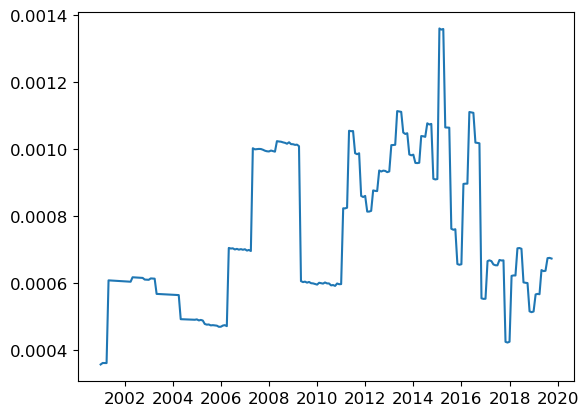

In [48]:
plt.plot(ols.resid)

In [49]:
adfuller(ols.resid)

(-2.034737374812593,
 0.27155266174023857,
 12,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 -3375.4214847502553)